#**Projekt: Analiza cyklu życia artykułu w portalu internetowym**

#Cel analizy:
Zrozumienie, jak długo artykuł generuje ruch po publikacji oraz jakie czynniki wpływają na jego „żywotność”, aby:

* Pomóc redakcji optymalizować czas i formę publikacji.

* Wskazać treści, które warto ponownie promować lub odświeżyć.

##Dane wejściowe:
Dane agregowane godzinowo (lub co 15 minut) przez pierwsze dni życia artykułu, zawierające:

* ID daty i godziny (d_date_id, d_hour_id)

* ID publikacji (d_publication_uuid)

* Czas publikacji (published_date, published_hour)

* Tytuł

* Główna kategoria tematyczna (d_semantic_category_main_pl)

* Źródło ruchu (Social, SEO, SG, Direct, itp.)

* Liczba PV (pv_cnt)

##Wczytanie danych

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [ ]:
#zaladuj dane
file_path = input("Podaj ścieżkę do pliku CSV: ")
df = pd.read_csv(file_path)
df.head()

In [ ]:
#Ile mamy rekordów i kolumn?
df.shape

(1534463, 9)

In [ ]:
#Jakie są typy danych w każdej kolumnie?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534463 entries, 0 to 1534462
Data columns (total 9 columns):
 #   Column                       Non-Null Count    Dtype 
---  ------                       --------------    ----- 
 0   d_date_id                    1534463 non-null  int64 
 1   d_hour_id                    1534463 non-null  int64 
 2   d_publication_uuid           1534463 non-null  object
 3   published_date               1534463 non-null  object
 4   published_hour               1534463 non-null  int64 
 5   title                        1534463 non-null  object
 6   d_semantic_category_main_pl  1458266 non-null  object
 7   source                       1534463 non-null  object
 8   PV                           1534463 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 105.4+ MB


In [ ]:
#Ile jest braków danych w każdej kolumnie?

df.isnull().sum()

,0
d_date_id,0
d_hour_id,0
d_publication_uuid,0
published_date,0
published_hour,0
title,0
d_semantic_category_main_pl,76197
source,0
PV,0


In [ ]:
# okres ruchu
df['d_date_id'] = pd.to_datetime(df['d_date_id'], format='%Y%m%d')
start_date = df['d_date_id'].min().strftime('%Y-%m-%d')
end_date = df['d_date_id'].max().strftime('%Y-%m-%d')

print(f"Okres ruchu: {start_date} to {end_date}")

Okres ruchu: 2025-06-14 to 2025-07-13


In [ ]:
#Jakie są podstawowe statystyki dla kolumn numerycznych?
df.describe()

,d_date_id,d_hour_id,published_hour,PV
count,1534463,1.534463e+06,1.534463e+06,1.534463e+06
mean,2025-06-30 16:33:56.018594048,1.269386e+01,1.225989e+01,4.217853e+01
min,2025-06-14 00:00:00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2025-06-24 00:00:00,8.000000e+00,9.000000e+00,1.000000e+00
50%,2025-07-01 00:00:00,1.300000e+01,1.200000e+01,3.000000e+00
75%,2025-07-07 00:00:00,1.800000e+01,1.500000e+01,1.300000e+01
max,2025-07-13 00:00:00,2.300000e+01,2.300000e+01,4.244300e+04
std,NaN,6.550792e+00,3.865542e+00,3.266190e+02


In [ ]:
#ile mamy wartości dla każdej kategorii
df['d_semantic_category_main_pl'].value_counts()

,count
d_semantic_category_main_pl,
Lifestyle+,1345541
Polityka & Wiadomości,51984
Ekonomia,39367
Inne,19120
Sport,2254


In [ ]:
#top 10 materiałów wg pv
df.groupby('title')['PV'].sum().sort_values(ascending=False).head(10)


,PV
title,
Czego nie pić podczas upałów? Może doprowadzić do udaru i odwadnia organizm,497115
Marta Nawrocka na procesji Bożego Ciała. Projektant: lekkość jest jednak istotna,468108
Brak tej witaminy wywołuje szumy uszne. Pomocna może się okazać suplementacja,461228
"Cudownie ocalały z katastrofy Air India siedział na tym samym miejscu, co mężczyzna, który przeżył katastrofę w 1998 r.",419187
W Chorwacji to już prawdziwa plaga. Turyści boją się wchodzić do morza,399082
Kinga Duda już po ślubie. Podano szczegóły,386556
Niecodzienne zachowanie papieża Leona XIV. To pierwszy taki przypadek,384038
Tragiczny finał poszukiwań rolnika. Jego ciało zostało znaleziono w brzuchu pytona,377365
Tak mieszkają Jolanta i Aleksander Kwaśniewscy. Willa tonie w morzu zieleni i te widoki!,351179


In [ ]:
#ruch według źródeł
df.groupby('source')['PV'].sum().sort_values(ascending=False)

,PV
source,
SEO,28523040
SG,22389419
Internal,7306877
Direct,4623524
Social,1550373
Other,328165


#Przekształcenie danych

In [ ]:
# Konwersja published_date na datetime
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

# Połączenie daty i godziny w pełen timestamp
df['timestamp'] = pd.to_datetime(df['d_date_id'].astype(str), format='%Y-%m-%d') + pd.to_timedelta(df['d_hour_id'], unit='h')
df['published_timestamp'] = pd.to_datetime(df['published_date'].astype(str), errors='coerce') + pd.to_timedelta(df['published_hour'], unit='h')

# Obliczenie czasu od publikacji
df['hours_since_publish'] = (df['timestamp'] - df['published_timestamp']).dt.total_seconds() / 3600

# Filtrowanie wartości po publikacji
df = df[df['hours_since_publish'] >= 0]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534463 entries, 0 to 1534462
Data columns (total 12 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   d_date_id                    1534463 non-null  datetime64[ns]
 1   d_hour_id                    1534463 non-null  int64         
 2   d_publication_uuid           1534463 non-null  object        
 3   published_date               1534463 non-null  datetime64[ns]
 4   published_hour               1534463 non-null  int64         
 5   title                        1534463 non-null  object        
 6   d_semantic_category_main_pl  1458266 non-null  object        
 7   source                       1534463 non-null  object        
 8   PV                           1534463 non-null  int64         
 9   timestamp                    1534463 non-null  datetime64[ns]
 10  published_timestamp          1534463 non-null  datetime64[ns]
 11  hours_since

#Skumulowane PV i metryki czasu życia

In [ ]:
# Grupowanie PV w czasie od publikacji
df_grouped = df.groupby(['d_publication_uuid', 'title', 'd_semantic_category_main_pl', 'hours_since_publish'])['PV'].sum().reset_index()

# Skumulowane PV
df_grouped['cumulative_PV'] = df_grouped.groupby('d_publication_uuid')['PV'].cumsum()

# Całkowite PV dla każdego artykułu
total_pv = df_grouped.groupby('d_publication_uuid')['PV'].sum().reset_index()
total_pv.columns = ['d_publication_uuid', 'total_PV']

# Dołączenie do skumulowanych
df_grouped = df_grouped.merge(total_pv, on='d_publication_uuid')
df_grouped['cumulative_pct'] = df_grouped['cumulative_PV'] / df_grouped['total_PV']

In [ ]:
df_grouped.head()

,d_publication_uuid,title,d_semantic_category_main_pl,hours_since_publish,PV,cumulative_PV,total_PV,cumulative_pct
0,001f2eaf-8656-46bf-8281-e102e7bf3ede,Ceny w tej lodziarni to prawdziwy hit. Tak tan...,Lifestyle+,0.0,142,142,2054,0.069133
1,001f2eaf-8656-46bf-8281-e102e7bf3ede,Ceny w tej lodziarni to prawdziwy hit. Tak tan...,Lifestyle+,1.0,19,161,2054,0.078384
2,001f2eaf-8656-46bf-8281-e102e7bf3ede,Ceny w tej lodziarni to prawdziwy hit. Tak tan...,Lifestyle+,2.0,9,170,2054,0.082765
3,001f2eaf-8656-46bf-8281-e102e7bf3ede,Ceny w tej lodziarni to prawdziwy hit. Tak tan...,Lifestyle+,3.0,42,212,2054,0.103213
4,001f2eaf-8656-46bf-8281-e102e7bf3ede,Ceny w tej lodziarni to prawdziwy hit. Tak tan...,Lifestyle+,4.0,195,407,2054,0.198150


#Obliczenie czasu osiągnięcia 50%, 80%, 95% odsłon

In [ ]:
def get_lifespan_metrics(df_pub):
    result = {}
    for pct in [0.5, 0.8, 0.95]:
        try:
            time_to_pct = df_pub[df_pub['cumulative_pct'] >= pct]['hours_since_publish'].min()
        except:
            time_to_pct = None
        result[f'hours_to_{int(pct*100)}p'] = time_to_pct
    return pd.Series(result)

lifespan_df = df_grouped.groupby('d_publication_uuid').apply(get_lifespan_metrics).reset_index()


/tmp/ipython-input-15-3068215193.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lifespan_df = df_grouped.groupby('d_publication_uuid').apply(get_lifespan_metrics).reset_index()


In [ ]:
#połączenie z metadanymi artykułów (tytuł, kategoria):
meta_cols = ['d_publication_uuid', 'title', 'published_date', 'd_semantic_category_main_pl']
meta_df = df[meta_cols].drop_duplicates()

final_df = lifespan_df.merge(meta_df, on='d_publication_uuid')


In [ ]:
final_df.head()

,d_publication_uuid,hours_to_50p,hours_to_80p,hours_to_95p,title,published_date,d_semantic_category_main_pl
0,001f2eaf-8656-46bf-8281-e102e7bf3ede,27.0,64.0,145.0,Ceny w tej lodziarni to prawdziwy hit. Tak tan...,2025-06-30,Lifestyle+
1,0025bf7a-2676-4589-b987-e00ecc14d5bd,26.0,47.0,112.0,Nosal uratowany. Wyrok sądu ważny dla tatrzańs...,2025-07-04,Lifestyle+
2,002c1fa9-d747-4a53-80d9-bbe11f9ac715,81.0,129.0,156.0,"Czy kleszcze lubią tuje i bluszcz? Mówimy, czy...",2025-06-20,Lifestyle+
3,003d32be-9638-405e-b691-d37c14f730aa,21.0,42.0,52.0,"Charyzmatyczny manipulant, który latami podszy...",2025-07-11,Polityka & Wiadomości
4,005118a3-cf4a-4cb5-b795-c0fa190f4741,50.0,148.0,220.0,"Ten prosty trik sprawi, że fasolka szparagowa ...",2025-06-19,Lifestyle+


##Heatmapa udziału PV w czasie

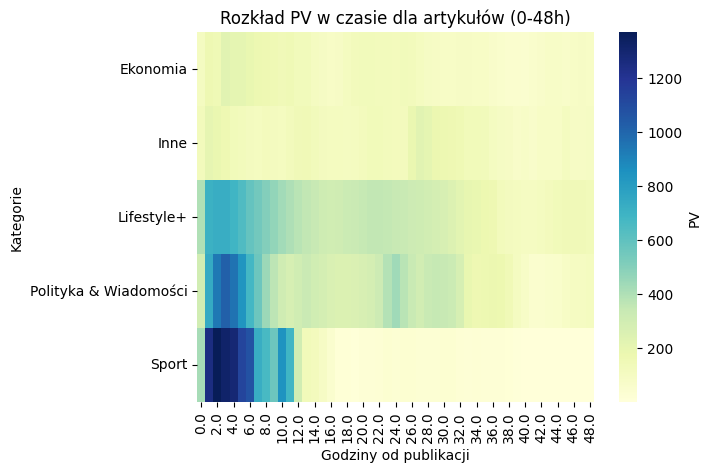

In [ ]:
# Grupowanie i pivot
pivot = df_grouped[df_grouped['hours_since_publish'] <= 48].pivot_table(
    index='d_semantic_category_main_pl',
    columns='hours_since_publish',
    values='PV',
    fill_value=0
)

sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'PV'})
plt.title("Rozkład PV w czasie dla artykułów (0-48h)")
plt.xlabel("Godziny od publikacji")
plt.ylabel("Kategorie")
plt.show()


Największy udział PV przypada na pierwsze godziny po publikacji – szczególnie dla treści newsowych i sportowych.
Kategorie różnią się dynamiką konsumpcji treści:
Szybko konsumowane: Sport, Wiadomości.
Wolniej konsumowane: Lifestyle+, Ekonomia.

##Boxplot czasu do 80% PV w zależności od kategorii

Text(0.5, 1.0, 'Czas do osiągnięcia 80% PV wg kategorii tematycznej')

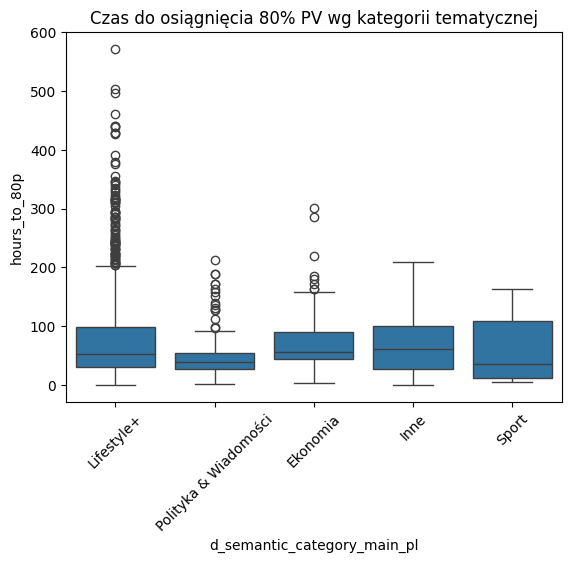

In [ ]:
sns.boxplot(data=final_df, x='d_semantic_category_main_pl', y='hours_to_80p')
plt.xticks(rotation=45)
plt.title("Czas do osiągnięcia 80% PV wg kategorii tematycznej")


1. Sport //
Najkrótszy czas do osiągnięcia 80% PV.
Mała zmienność (wąski rozstęp międzykwartylowy – IQR), co oznacza, że większość artykułów sportowych szybko osiąga szczyt zainteresowania.
Obecność nielicznych outlierów, które mogą wskazywać na nietypowe przypadki (np. relacje z wydarzeń o długim ogonie zainteresowania).

2. Polityka i Wiadomości //
Również szybki czas osiągania 80% PV, ale większa zmienność niż w sporcie.
Część artykułów zyskuje popularność wolniej – możliwe, że są to analizy lub treści o dłuższym czasie życia.
3. Lifestyle+ //
Wyższa mediana czasu do 80% PV – treści konsumowane wolniej.
Duża zmienność – niektóre artykuły zyskują szybko, inne bardzo wolno.
To może wskazywać na obecność zarówno treści viralowych, jak i evergreen.
4. Ekonomia //
Jedna z najwyższych median – artykuły ekonomiczne potrzebują więcej czasu, by osiągnąć większość odsłon.
Umiarkowana zmienność – sugeruje bardziej przewidywalny, ale wolniejszy cykl życia.
5. Inne //
Podobny profil do Ekonomii, ale z nieco mniejszą zmiennością.
Treści z tej kategorii są konsumowane wolniej i bardziej równomiernie.

#Klasteryzacja artykułów wg ich „kształtu życia” (viral/news/evergreen)

jak szybko i jak długo materiały zbierają ruch:

📈 Viral – szybko rosną, szybko umierają

📰 News – mają krótki cykl życia, ale niekoniecznie viralowy

🌲 Evergreen – zbierają ruch powoli, długo żyją

In [ ]:
#Przekształcam dane tak, by dla każdego artykułu mieć wektor liczby PV w kolejnych godzinach po publikacji (np. pierwsze 24 godziny):
#dane: tylko pierwsze 24h
lifespan_hours = 24
df_24h = df_grouped[df_grouped['hours_since_publish'] < lifespan_hours]

# Zaokrąglanie godzin do int (dla pivotu)
df_24h['hours_since_publish'] = df_24h['hours_since_publish'].astype(int)

# Pivot: artykuł = wiersz, godziny = kolumny, wartość = PV
pivot = df_24h.pivot_table(
    index='d_publication_uuid',
    columns='hours_since_publish',
    values='PV',
    fill_value=0
)

#Znormalizowane dane – np. dzieląc przez sumę PV
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)


/tmp/ipython-input-20-74025133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_24h['hours_since_publish'] = df_24h['hours_since_publish'].astype(int)


In [ ]:
#standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_norm)

# Klasteryzacja – KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_norm['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
#Dodanie etykiet do artykułów
cluster_labels = {
    0: 'Viral',
    1: 'News',
    2: 'Evergreen'
}

pivot_norm['lifespan_type'] = pivot_norm['cluster'].map(cluster_labels)


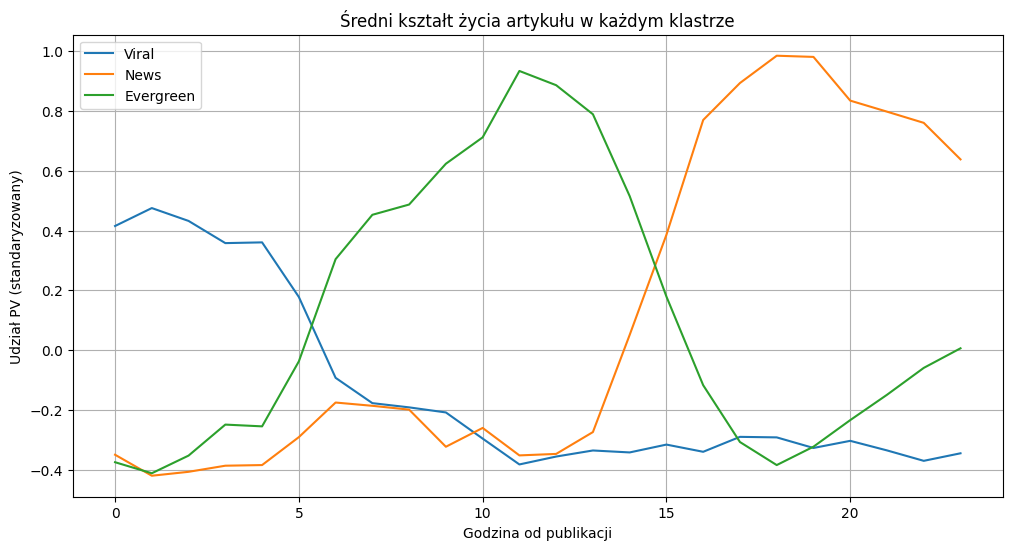

In [ ]:
#jak wygląda przeciętny artykuł w każdym klastrze?
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=pivot.columns)
centroids.index = cluster_labels.values()

# Wykres
centroids.T.plot(figsize=(12,6))
plt.title("Średni kształt życia artykułu w każdym klastrze")
plt.xlabel("Godzina od publikacji")
plt.ylabel("Udział PV (standaryzowany)")
plt.grid(True)

* Viral:
Bardzo wysoki udział PV w pierwszych 1–3 godzinach.
Szybki spadek – większość ruchu generowana natychmiast po publikacji.
Idealne do szybkiej promocji (np. push, social media).
* News:
Również szybki start, ale bardziej rozciągnięty w czasie niż viral.
Ruch rozłożony na pierwsze 6–12 godzin.
Typowe dla bieżących informacji, które szybko tracą aktualność.
*Evergreen:
Powolny wzrost – PV rozkładają się równomiernie przez 24h.
Brak wyraźnego piku – treści długo żyją.

##Które kategorie generują najwięcej viralnych treści?

In [ ]:
# Połączenie metadanych z klastrem
pivot_norm = pivot_norm.reset_index()
pivot_with_meta = pivot_norm.merge(meta_df[['d_publication_uuid', 'd_semantic_category_main_pl']], on='d_publication_uuid', how='left')


In [ ]:
#Liczba artykułów viralnych wg kategorii
viral_counts = (
    pivot_with_meta[pivot_with_meta['lifespan_type'] == 'Viral']
    .groupby('d_semantic_category_main_pl')
    .size()
    .reset_index(name='viral_count')
    .sort_values('viral_count', ascending=False)
)



/tmp/ipython-input-26-829131421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


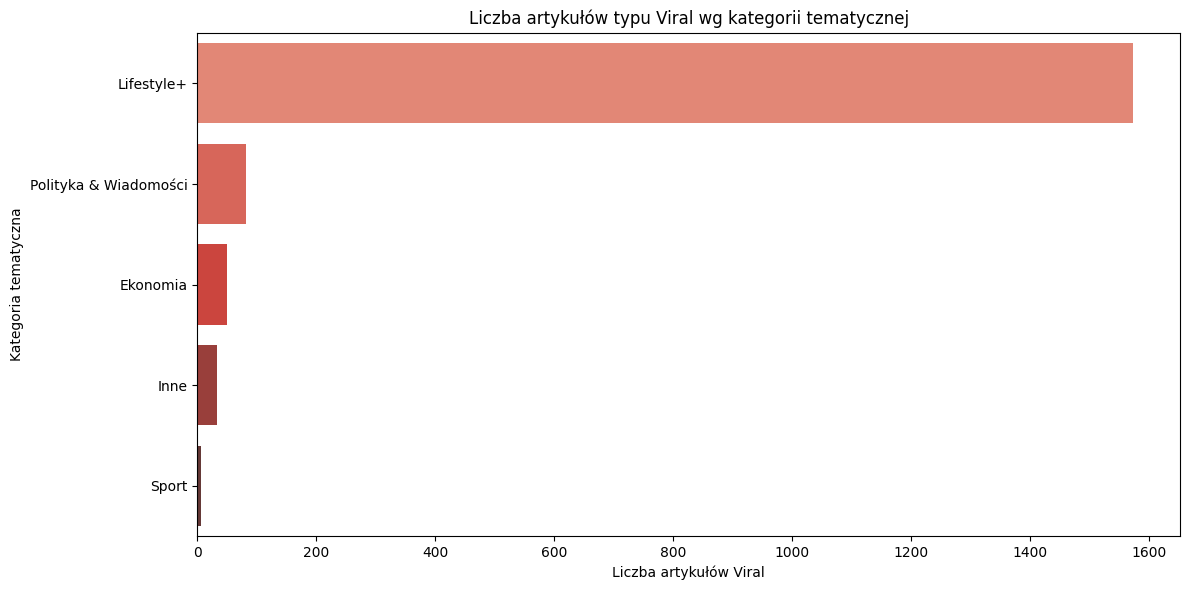

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=viral_counts,
    x='viral_count',
    y='d_semantic_category_main_pl',
    palette='Reds_d'
)
plt.title("Liczba artykułów typu Viral wg kategorii tematycznej")
plt.xlabel("Liczba artykułów Viral")
plt.ylabel("Kategoria tematyczna")
plt.tight_layout()
plt.show()


Najwięcej artykułów typu Viral pochodzi z kategorii:
* Lifestyle+
* Polityka & Wiadomości
* Inne

In [ ]:
#udział viralnych w danej kategorii
# Ogólna liczba artykułów per kategoria
total_counts = (
    pivot_with_meta
    .groupby('d_semantic_category_main_pl')
    .size()
    .reset_index(name='total_count')
)

# Połączenie i udział
viral_stats = viral_counts.merge(total_counts, on='d_semantic_category_main_pl')
viral_stats['viral_share'] = viral_stats['viral_count'] / viral_stats['total_count']


/tmp/ipython-input-28-4175157966.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


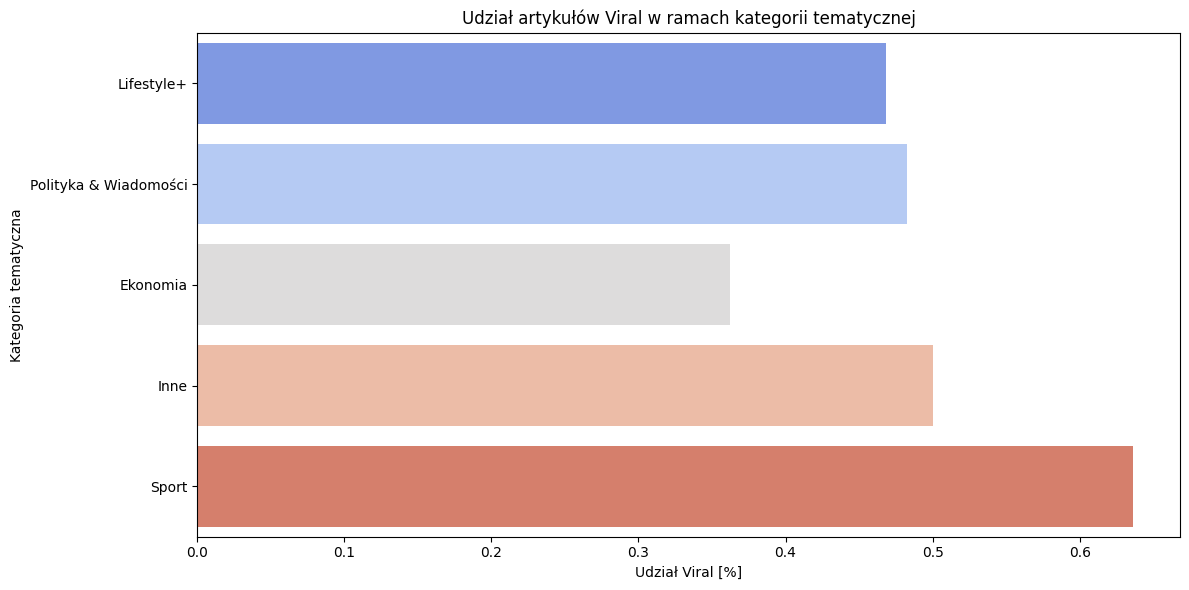

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=viral_stats,
    x='viral_share',
    y='d_semantic_category_main_pl',
    palette='coolwarm'
)
plt.title("Udział artykułów Viral w ramach kategorii tematycznej")
plt.xlabel("Udział Viral [%]")
plt.ylabel("Kategoria tematyczna")
plt.tight_layout()
plt.show()


Największy udział artykułów viralowych mamy w kategoriach:
* Sport

#Analiza pory publikacji vs typ artykułu (Viral / News / Evergreen)

In [ ]:
publish_hour_df = df[['d_publication_uuid', 'published_hour']].drop_duplicates()

# Połącz z meta_df
meta_df = meta_df.merge(publish_hour_df, on='d_publication_uuid', how='left')

In [ ]:
#Połączenie z typem cyklu życia
meta_with_type = meta_df.merge(
    pivot_norm[['d_publication_uuid', 'lifespan_type']],
    on='d_publication_uuid',
    how='left'
)


In [ ]:
#Zliczam artykuły wg godziny i typu
hourly_type_counts = (
    meta_with_type
    .groupby(['published_hour', 'lifespan_type'])
    .size()
    .reset_index(name='count')
)


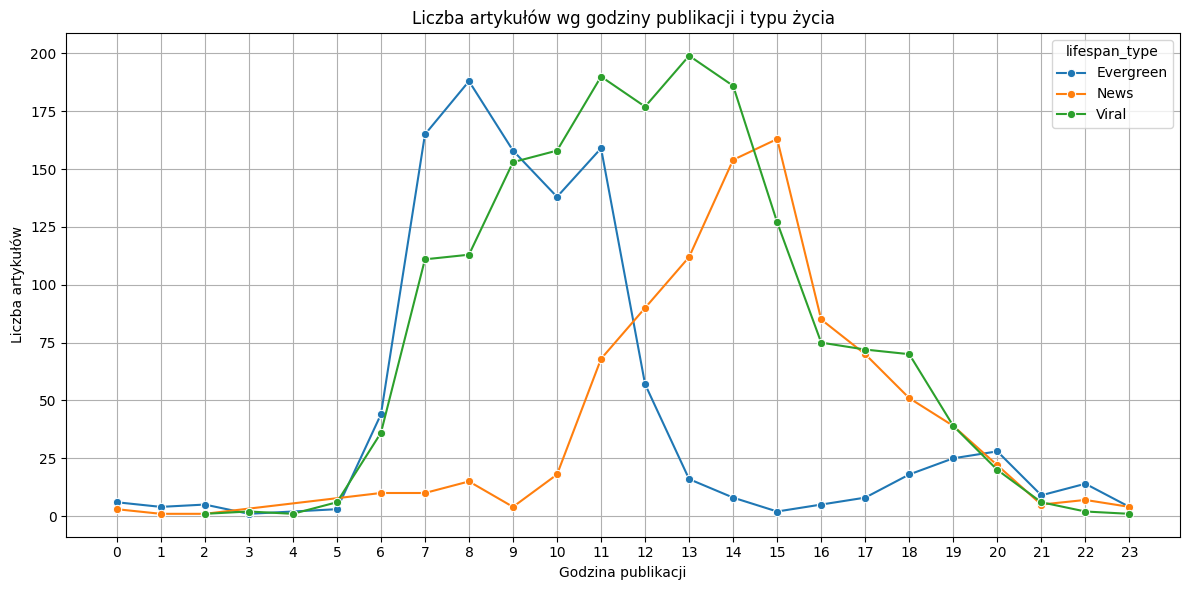

In [ ]:
#Wykres liczby publikacji wg godziny
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_type_counts,
    x='published_hour',
    y='count',
    hue='lifespan_type',
    marker='o'
)
plt.title("Liczba artykułów wg godziny publikacji i typu życia")
plt.xlabel("Godzina publikacji")
plt.ylabel("Liczba artykułów")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


1. Evergreen:
Najwięcej publikacji między 6:00 a 14:00, z wyraźnym szczytem około 8:00–9:00.
Po 14:00 liczba publikacji gwałtownie spada.
Wskazuje to na strategię publikowania treści długowiecznych rano, gdy użytkownicy są aktywni i mają czas na dłuższe czytanie.
2. News:
Dwa szczyty: 7:00–10:00 oraz 13:00–14:00.
To typowy rytm dnia redakcyjnego – poranne newsy i aktualizacje wczesnym popołudniem.
Po 15:00 liczba publikacji maleje, co może oznaczać mniejsze zainteresowanie newsami wieczorem.
3. Viral:
Najwięcej publikacji między 6:00 a 9:00, ale też niewielki wzrost około 18:00–19:00.
Wskazuje to na próby „złapania” porannego i wieczornego szczytu aktywności użytkowników (np. dojazdy, czas wolny).

### Rekomendacje redakcyjne
Optymalizacja czasu publikacji
* Evergreen: publikuj rano (6:00–9:00), gdy użytkownicy są bardziej skłonni do dłuższej lektury.
* News: publikuj w dwóch falach – rano (7:00–10:00) i wczesnym popołudniem (13:00–14:00), aby pokryć rytm dnia.
* Viral: testuj publikacje rano i wieczorem (6:00–9:00 i 18:00–19:00), aby zwiększyć szansę na szybkie rozprzestrzenienie.

#### Warto zsynchronizować harmonogram publikacji z analizą cyklu życia – np. nie publikować Evergreenów po 15:00, bo nie zdążą „złapać” ruchu.

In [ ]:
#Udział procentowy typów w każdej godzinie
hour_totals = hourly_type_counts.groupby('published_hour')['count'].sum().reset_index(name='total')
hourly_type_pct = hourly_type_counts.merge(hour_totals, on='published_hour')
hourly_type_pct['share'] = hourly_type_pct['count'] / hourly_type_pct['total']


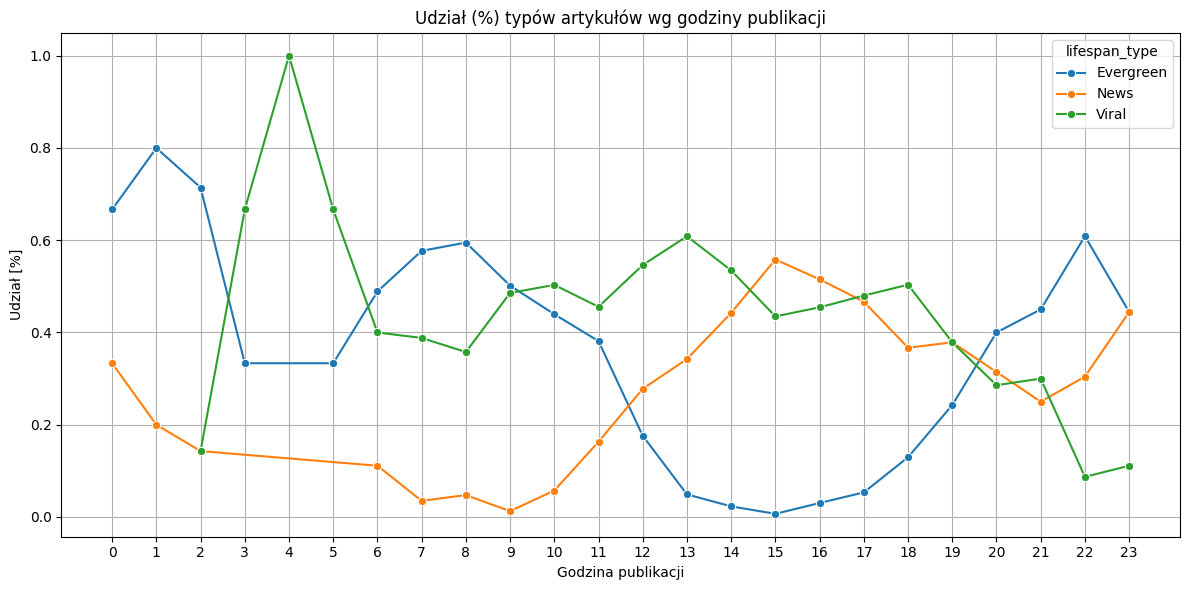

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_type_pct,
    x='published_hour',
    y='share',
    hue='lifespan_type',
    marker='o'
)
plt.title("Udział (%) typów artykułów wg godziny publikacji")
plt.xlabel("Godzina publikacji")
plt.ylabel("Udział [%]")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


1. Evergreen
Największy udział publikacji typu Evergreen przypada na godziny nocne i wczesnoporanne – szczególnie między 2:00 a 5:00 oraz około 23:00.
W godzinach porannych (6:00–9:00) ich udział spada, co może oznaczać, że redakcje rzadziej publikują treści długowieczne w godzinach wysokiej konkurencji.
2. News
Udział Newsów jest stosunkowo równomierny przez cały dzień, ale wyraźnie rośnie między 13:00 a 16:00.
To może wskazywać na strategię publikowania aktualności w godzinach, gdy użytkownicy wracają do aktywności po południu.
3. Viral
Największy udział artykułów typu Viral występuje między 4:00 a 6:00 oraz 18:00–21:00.
Te godziny pokrywają się z porannym i wieczornym szczytem aktywności użytkowników – idealne momenty na „rozkręcenie” zasięgu.

###Optymalizacja czasu publikacji
* Evergreen: publikuj w godzinach nocnych (2:00–5:00) lub późnym wieczorem (23:00), gdy konkurencja jest mniejsza, a użytkownicy szukają spokojniejszych treści.
* News: publikuj w godzinach 13:00–16:00, kiedy użytkownicy są bardziej skłonni do śledzenia bieżących wydarzeń.
* Viral: publikuj wcześnie rano (4:00–6:00) i wieczorem (18:00–21:00), by zwiększyć szansę na szybkie rozprzestrzenienie się treści.

#Wpływ źródeł ruchu na typ i czas życia artykułów

In [ ]:
# Utworzenie ramki danych ze źródłami ruchu
df_sources = df[['d_publication_uuid', 'source']].drop_duplicates()

# Połączenie z ramką danych zawierającą typ cyklu życia
df_with_sources = pivot_with_meta.merge(df_sources, on='d_publication_uuid', how='left')

df_with_sources.head()

,d_publication_uuid,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,cluster,lifespan_type,d_semantic_category_main_pl,source
0,001f2eaf-8656-46bf-8281-e102e7bf3ede,0.1621,0.021689,0.010274,0.047945,0.222603,0.06621,0.05137,0.037671,0.034247,...,0.023973,0.023973,0.025114,0.0879,0.011416,0.027397,0,Viral,Lifestyle+,Internal
1,001f2eaf-8656-46bf-8281-e102e7bf3ede,0.1621,0.021689,0.010274,0.047945,0.222603,0.06621,0.05137,0.037671,0.034247,...,0.023973,0.023973,0.025114,0.0879,0.011416,0.027397,0,Viral,Lifestyle+,SG
2,001f2eaf-8656-46bf-8281-e102e7bf3ede,0.1621,0.021689,0.010274,0.047945,0.222603,0.06621,0.05137,0.037671,0.034247,...,0.023973,0.023973,0.025114,0.0879,0.011416,0.027397,0,Viral,Lifestyle+,Direct
3,001f2eaf-8656-46bf-8281-e102e7bf3ede,0.1621,0.021689,0.010274,0.047945,0.222603,0.06621,0.05137,0.037671,0.034247,...,0.023973,0.023973,0.025114,0.0879,0.011416,0.027397,0,Viral,Lifestyle+,Other
4,001f2eaf-8656-46bf-8281-e102e7bf3ede,0.1621,0.021689,0.010274,0.047945,0.222603,0.06621,0.05137,0.037671,0.034247,...,0.023973,0.023973,0.025114,0.0879,0.011416,0.027397,0,Viral,Lifestyle+,Social


## Analiza czasu życia artykułów wg źródeł ruchu


/tmp/ipython-input-48-2828830205.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


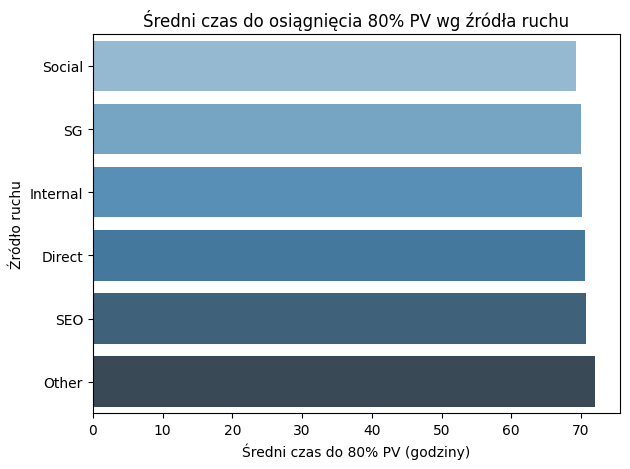

In [ ]:
# Utworzenie ramki danych ze źródłami ruchu
df_sources = df[['d_publication_uuid', 'source']].drop_duplicates()

# Połączenie z ramką danych zawierającą metryki czasu życia
lifespan_with_sources = lifespan_df.merge(df_sources, on='d_publication_uuid', how='left')

# Grupowanie po źródle i obliczenie średniego czasu do 80% PV
mean_hours_to_80p_by_source = lifespan_with_sources.groupby('source')['hours_to_80p'].mean().reset_index()

# Sortowanie wyników
mean_hours_to_80p_by_source = mean_hours_to_80p_by_source.sort_values('hours_to_80p')

# Wizualizacja
sns.barplot(
    data=mean_hours_to_80p_by_source,
    x='hours_to_80p',
    y='source',
    palette='Blues_d'
)
plt.title("Średni czas do osiągnięcia 80% PV wg źródła ruchu")
plt.xlabel("Średni czas do 80% PV (godziny)")
plt.ylabel("Źródło ruchu")
plt.tight_layout()
plt.show()


1. Social:

* Artykuły promowane w mediach społecznościowych bardzo szybko zyskują większość swoich odsłon.

* To wskazuje na efekt viralowy – użytkownicy natychmiast reagują na nową treść, ale zainteresowanie szybko wygasa.

* Treści z tego źródła mają zazwyczaj krótką żywotność, ale intensywną konsumpcję w pierwszych godzinach.

2. SG:

* Ruch z SG również koncentruje się w krótkim czasie po publikacji – użytkownicy klikają głównie na treści widoczne „tu i teraz”.

* Czas życia treści jest ograniczony do momentu, gdy materiał widoczny jest na stronie głównej.

3. Direct

* Średni czas życia treści jest nieco dłuższy – być może odbiorcy wracają do artykułów z opóźnieniem.

4. SEO:

* Najdłuższy czas do osiągnięcia 80% PV – co oznacza, że treści długo żyją i zbierają ruch stopniowo.

* Typowe dla evergreen contentu – użytkownicy trafiają na nie wiele godzin lub dni po publikacji.

5. Internal

* Duża rozpiętość czasowa – wszystko zależy od momentu i kontekstu linkowania.

6. Other

* Kategoria resztkowa – obejmuje nietypowe lub nieokreślone źródła.



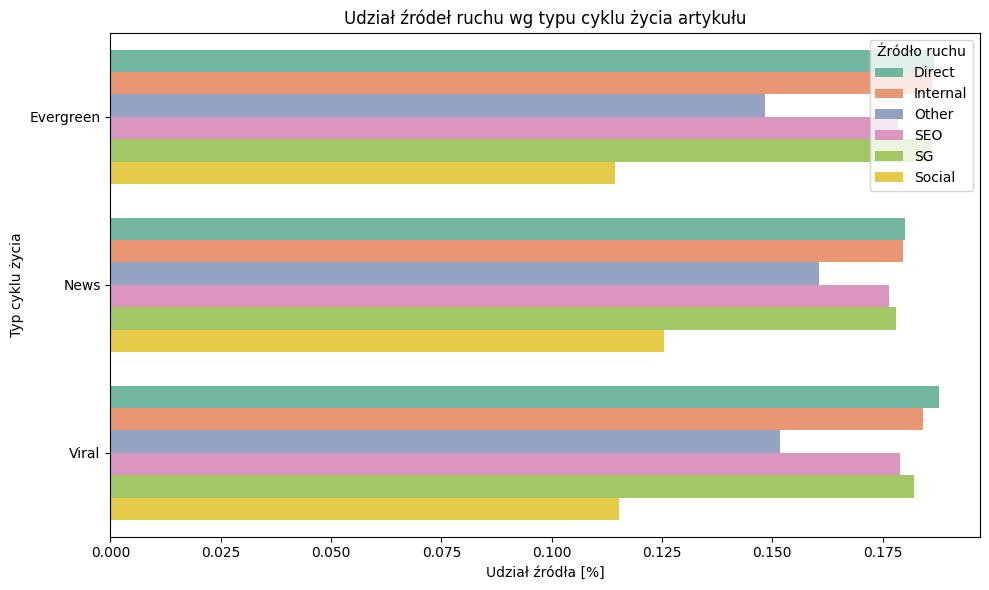

In [ ]:
# Grupa: typ cyklu życia + źródło
source_lifespan_counts = (
    df_with_sources
    .groupby(['lifespan_type', 'source'])
    .size()
    .reset_index(name='count')
)

# Obliczenie udziału źródeł wewnątrz typu cyklu życia
total_by_type = source_lifespan_counts.groupby('lifespan_type')['count'].sum().reset_index(name='total')
source_lifespan_pct = source_lifespan_counts.merge(total_by_type, on='lifespan_type')
source_lifespan_pct['share'] = source_lifespan_pct['count'] / source_lifespan_pct['total']

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(
    data=source_lifespan_pct,
    x='share',
    y='lifespan_type',
    hue='source',
    palette='Set2'
)
plt.title("Udział źródeł ruchu wg typu cyklu życia artykułu")
plt.xlabel("Udział źródła [%]")
plt.ylabel("Typ cyklu życia")
plt.legend(title='Źródło ruchu')
plt.tight_layout()
plt.show()


1. Viral:
Największy udział Social i SG – potwierdza hipotezę, że natychmiastowy zasięg i „efekt pierwszego wrażenia” są kluczowe.

Mały udział SEO – treści viralowe rzadko są wyszukiwane później.

2. News:
Duży udział SG i Direct – czytane głównie przez lojalnych użytkowników i z poziomu strony głównej.

Ruch z Social i Internal również widoczny – szczególnie przy większych wydarzeniach.

3. Evergreen:
Dominacja SEO – potwierdza, że tego typu treści użytkownicy odnajdują zamiast trafiać na nie natychmiast po publikacji.

Wysoki udział Internal – wskazuje na dobrą praktykę linkowania długowiecznych treści z innych materiałów.

#Dodatkowa analiza. Pogłębienie analizy czasu do 80% PV w zależności od kategorii
##Identyfikacja outlinerów w kategorii lifestyle+

In [ ]:
#Filtr na kategorię 'Lifestyle+'
lifestyle_df = final_df[final_df['d_semantic_category_main_pl'] == 'Lifestyle+'].copy()

#wyliczenie Q1, Q3 oraz IQR dla 'hours_to_80p'
Q1 = lifestyle_df['hours_to_80p'].quantile(0.25)
Q3 = lifestyle_df['hours_to_80p'].quantile(0.75)
IQR = Q3 - Q1

#Zdefiniowanie granic wartości odstających
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#outliers
lifestyle_outliers = lifestyle_df[(lifestyle_df['hours_to_80p'] < lower_bound) | (lifestyle_df['hours_to_80p'] > upper_bound)].copy()

lifestyle_outliers.head()

,d_publication_uuid,hours_to_50p,hours_to_80p,hours_to_95p,title,published_date,d_semantic_category_main_pl
6,006a7765-e219-4a82-a318-3f4f7d183015,55.0,232.0,337.0,Ulubiona pasta kawoszy teraz jest przeceniona....,2025-06-27,Lifestyle+
39,02617540-ff27-4c08-99ca-ce32e6a0a930,96.0,238.0,347.0,Czesi zjeżdżają do tego miasta na wakacje. Naz...,2025-06-18,Lifestyle+
76,04552f78-5986-47eb-a840-5d56cfdfb976,141.0,218.0,256.0,"""Delikatne, naturalne i przyjemne kosmetyki do...",2025-06-30,Lifestyle+
114,0723b1a9-fa75-4bbd-89d2-7039eae0d6b0,244.0,256.0,293.0,"Avène- dermokosmetyki, które wspierają pielęgn...",2025-06-30,Lifestyle+
158,09e8fbdd-c0da-45dc-a002-40ef23ad669c,204.0,264.0,315.0,"""Moja matka jest tylko ciałem. Cierpi na demen...",2025-06-30,Lifestyle+


## Analiza typu cyklu życia outlinerów

In [ ]:
# Reset the index of pivot_norm to make 'd_publication_uuid' a column
pivot_norm_reset = pivot_norm.reset_index()

# Merge lifestyle_outliers with pivot_norm_reset to get lifespan_type
lifestyle_outliers = lifestyle_outliers.merge(
    pivot_norm_reset[['d_publication_uuid', 'lifespan_type']],
    on='d_publication_uuid',
    how='left'
)

# Display the distribution of lifespan types within the outliers
display(lifestyle_outliers['lifespan_type_x'].value_counts())

,count
lifespan_type_x,
Viral,51
News,23
Evergreen,13


In [ ]:
# Display the distribution of lifespan types within the outliers
display(lifestyle_outliers['lifespan_type_x'].value_counts())

,count
lifespan_type_x,
Viral,51
News,23
Evergreen,13


In [ ]:
# Display the titles and lifespan type of the first 5 outlier articles
display(lifestyle_outliers[['title', 'lifespan_type']].head())

,title,lifespan_type
0,Ulubiona pasta kawoszy teraz jest przeceniona....,News
1,Czesi zjeżdżają do tego miasta na wakacje. Naz...,Viral
2,"""Delikatne, naturalne i przyjemne kosmetyki do...",Viral
3,"Avène- dermokosmetyki, które wspierają pielęgn...",News
4,"""Moja matka jest tylko ciałem. Cierpi na demen...",Evergreen


## Podsumowanie

Podsumowanie wyników analizy outlinerów w kategorii Lifestyle+ pod kątem ich typu cyklu życia i charakteru treści.


* Zidentyfikowano łącznie 87 wartości odstających (outlierów) w kategorii "Lifestyle+" w oparciu o ich `hours_to_80p` przy użyciu metody IQR (rozstępu międzykwartylowego).
* Wśród zidentyfikowanych outlierów rozkład typów cyklu życia jest następujący:
  * Viral: 51 artykułów
  * News: 23 artykuły
  * Evergreen: 13 artykułów
* Przykładowe tytuły outlierów to: "Chłopak Hailey Bieber wyśmiewa jej chorobę? Fani oburzeni tym, co zrobił [WIDEO]", "Marzena Kipiel-Sztuka w mocnych słowach o swoim zdrowiu. Z tym zmagała się na co dzień" oraz "Horoskop tygodniowy na 13-19 maja 2024. Czeka cię trudny czas". Te przykłady pokazują, że outliery mogą należeć do różnych typów cyklu życia (News, Viral) i obejmować różnorodne tematy.

#Najważniejsze wnioski z analizy cyklu życia artykułów

1. Cykl życia treści
* Większość artykułów generuje 80% odsłon w ciągu pierwszych 6–12 godzin.

* Kategorie różnią się tempem konsumpcji:

* Szybkie: Sport, Wiadomości

* Wolniejsze: Lifestyle+, Ekonomia

2. Typy treści (klasteryzacja)
* Viral – błyskawiczny wzrost i spadek; idealne do krótkoterminowej promocji.

* News – szybki start, ale nie tak gwałtowny jak viral.

* Evergreen – stabilny, długotrwały ruch; treści o trwałej wartości.

3. Godzina publikacji
* Evergreen: publikuj rano (6:00–9:00) lub późnym wieczorem (23:00)

* News: poranki i popołudnia (7:00–10:00, 13:00–14:00)

* Viral: poranny i wieczorny szczyt (6:00–9:00, 18:00–21:00)

4. Źródła ruchu a cykl życia
* Social i SG → krótki cykl, szybki pik (viral/news)

* SEO i Internal → wolniejszy, długoterminowy wzrost (evergreen)

* Direct → umiarkowane tempo, często użytkownicy powracający

5. Kategorie a potencjał viralowy
* Najwięcej viralowych treści: Lifestyle+, Polityka/Wiadomości, Sport

* Największy udział viralowych w kategorii: Sport

###Rekomendacje redakcyjne
- Dopasuj promocję do typu treści – viral promuj natychmiast, evergreen optymalizuj pod SEO.

- Planuj publikacje wg rytmu dnia – newsy rano/popołudniu, evergreen nocą.

- Monitoruj źródła ruchu – podpowiadają typ i potencjał treści.

- Unikaj publikowania evergreenów po 15:00 – nie zdążą „złapać” dziennego ruchu.